# LINCS Publications & Citations Report

*Created by Brian M. Schilder, Moshe Silverstein, and Alexandra Keenan on 09/22/2018.*

In [1]:
%matplotlib inline

import sys
print (sys.version)
# token: 428145730f2d00b0596bd2521918df095fc272a23500acb4
import os
os.getcwd()
os.chdir('../LINCS-Publications-Report')

3.6.3 (v3.6.3:2c5fed86e0, Oct  3 2017, 00:32:08) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary
- Plots:
	- Publications over time
	- Citations over time


- Repeat these plots for each of the following groupings:
	- Aggregated across internal LINCS centers

	- Divided amongst internal LINCS centers (label by center, not PI)
		1. Data Coordination and Integration Center (Mount Sinai, Avi Ma’ayan)
		2. Drug Toxicity Signature Generation Center (Mount Sinai, Ravi Iyengar)
		3. LINCS Proteomic Characterization Center for Signaling and Epigenetics (Broad Institute, Jacob Jaffe)
		4. Microenvironment Perturbagen (MEP) LINCS Center (Oregon Health & Science University, Joe Gray)
		5.	HMS LINCS Center (Peter Sorger)
		6.	LINCS Center for Transcriptomics (Broad Institute, Todd Golub)
		7.	NeuroLINCS Center  (UC-Irvine, Leslie Thompson)
	- Across all groups external to LINCS (E.g. papers that used L1000, Canvas Browser).; 

### Import Data

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sn.set_style('whitegrid')
sn.set(font_scale=1.5) 
# Author info from LINCS database (collected 
authors = pd.read_table('authors.tsv')
authors.rename(columns={'id':'author_id'}, inplace=True)

authors_pubs = pd.read_table('authors_publications.tsv')
authorKey = authors.merge(authors_pubs, on='author_id')


# Publications (internal and external to the LINCS centers)
# Collected by Moshe Silverstein
## had to manually correct a couple errors in file
pubs = pd.read_table('publications.tsv') 
# Fill missing pub ids
maxID = int(max(pubs['id']))
fillerIDs = pd.Series(range(maxID, maxID+sum(pd.isnull(pubs['id'])) ))
pubs.fillna(fillerIDs, inplace=True)
# Rename cols
pubs.rename(columns={'id':'publication_id'}, inplace=True)  
# pubs['publication_id'] = pubs['publication_id'].astype(int)

# Get authors and concatenate
pubs_tmp = pubs.merge(authorKey, on='publication_id')
authorsConcat = pubs_tmp.groupby('publication_id')['name'].apply(lambda x: "%s" % ', '.join(x)).reset_index()
authorsConcat.rename(columns={'name':'authors'}, inplace=True) 
pubs = pubs.merge(authorsConcat, on='publication_id').drop_duplicates()  
pubs.columns
# Additional publications (internal and external to the LINCS centers)
#  collected by Alexandra Keenan
pubs2 = pd.read_csv('additional_pubs.csv')

def externalInternal(val):
    if val == 'outside':
        return 0
    else:
        return 1
pubs2['center_pub'] = pubs2['center'].apply(externalInternal)
pubs2 = pubs2.rename(columns={'PMID':'pm_id', 'year':'year_published', 'title':'article_name'})
pubs2['publication_id'] = max(pubs['publication_id'].astype(int)) 



# Add together all pubs
pubs_extended = pd.concat([pubs, pubs2],axis=0,  ignore_index=True)
# Fix pmc_id and pm_id
pubs_extended['pm_id'] =pubs_extended['pm_id'].fillna(0).astype(int)


### Get additional publications by searching grant numbers in PubMed API

In [3]:
import pandas as pd
grantIDs = pd.read_csv('LINCS_centers_by_grant.csv')

pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'+'db=pubmed&term='
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu'  
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08' 
urls = pubmed_url+grantIDs['grant'] +'[Grant+Number]'+'&datetype=edat&retmax=1000&usehistory=y'+\
       '&tool='+tool+'&email='+\
       email+'&api_key='+APIkey
url=urls[1]

from requests import get
import xmltodict   
import time 
def grants_to_pubs(url): 
    grant = url.split('&term=')[1].split("[Grant+Number]")[0] 
    response = get(str(url))
    resultsDict = xmltodict.parse(response.content)
    try:
        pmids = resultsDict['eSearchResult']['IdList']['Id']
        status = str(len(set(pmids)))+' publications found' 
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        pmids = []
        status = 'None found'
    print("Extracting Citations for grant : "+grant+"........ "+status)
    return pmids

res = map(grants_to_pubs, urls)
results = list(res) 


grantPubs_PMIDs=[]
for lst in results:
    grantPubs_PMIDs += lst

print('\n*********\n'+str(len(set(grantPubs_PMIDs))) +" unique publications found through grant PubMed API searches." )

    
grantPubs = dict(zip(grantIDs['grant'], results)) 


Extracting Citations for grant : U54-HG008097........ 10 publications found


Extracting Citations for grant : U54-HG008100........ 17 publications found


Extracting Citations for grant : U54-HL127624........ 66 publications found


Extracting Citations for grant : U54-HG008098........ 12 publications found


Extracting Citations for grant : U54-HL127365........ 36 publications found


Extracting Citations for grant : U54-HL127366........ 6 publications found


Extracting Citations for grant : U54-NS091046........ 23 publications found

*********
157 unique publications found through grant PubMed API searches.


### Add any new PMIDs to current list

In [4]:
# Add new PMIDs from pubmed grants search that aren't already included 
previousPMIDs = pubs_extended['pm_id'].fillna(0).astype(int)
previousPMIDs = previousPMIDs[previousPMIDs!=0].astype(str)
newPMIDs = set(grantPubs_PMIDs) - set(previousPMIDs)
print('PubMed grant search found '+str(len(newPMIDs))+' additional internal LINCS publications.')
newPMIDs_df = pd.DataFrame(pd.Series(list(newPMIDs), name='pm_id'))

pubs_extended = pubs_extended.merge(newPMIDs_df, on='pm_id',how='outer')
pubs_extended['pm_id'] = pubs_extended['pm_id'].astype(int)
pubs_extended.head()

PubMed grant search found 81 additional internal LINCS publications.


,abstract,analytical_method_development,article_name,assay_development,authors,center,center_pub,comments,created_at,data_analysis,...,publication_id,resource_links,review,scopus_citations,show_at_home_order,signature_generation,software_development,updated_at,volume,year_published
0,BACKGROUND: Thousands of biological and biomed...,1.0,Dynamics of the discovery process of protein-p...,0.0,"Wang Z, Ma'ayan A, Clark NC",NaN,1.0,NaN,5/19/16 18:33,1.0,...,1.0,"{\Custom code\"":null}""",0.0,NaN,NaN,0.0,1.0,5/19/16 18:33,9,2015.0
1,NaN,NaN,Dynamics of the discovery process of protein-p...,NaN,"Wang Z,Clark NR,Ma'ayan A",DCIC,1.0,funded in part by LINCS,NaN,NaN,...,214.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,2015.0
2,Wnt signaling plays a critical role in embryon...,0.0,A noncanonical Frizzled2 pathway regulates epi...,0.0,"Sorger PK, Gujral TS, Chan M, Peshkin L, Kirsc...",NaN,1.0,NaN,5/19/16 18:33,1.0,...,2.0,NaN,0.0,NaN,NaN,1.0,0.0,5/19/16 18:33,159,2014.0
3,"Drugs that inhibit RAF/MEK signaling, such as ...",0.0,Systematic analysis of BRAFV600E melanomas rev...,0.0,"Fallahi-Sichani M, Moerke NJ, Niepel M, Zhang ...",NaN,1.0,NaN,5/19/16 18:33,1.0,...,3.0,"{\Publication Summary\"":\""http://lincs.hms.har...",0.0,NaN,NaN,1.0,0.0,5/19/16 18:33,11,2015.0
4,Reconstructing regulatory and signaling respon...,1.0,Multitask learning of signaling and regulatory...,0.0,"Jain S, Gitter A, Bar-Joseph Z",NaN,1.0,NaN,5/19/16 18:33,1.0,...,4.0,"{\Custom code\"":null}""",0.0,NaN,NaN,0.0,1.0,5/19/16 18:33,10,2014.0


### Convert PMIDS to PMCs

In [5]:
converter_url =  'https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?'+\
                 'ids=' 
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMID_list = pubs_extended['pm_id'] 
PMID_list = PMID_list[PMID_list!=0].astype(str)

urls = converter_url+PMID_list +'&tool='+tool+'&email='+email+'&api_key='+APIkey+'&retmode=json'
url=urls[0]

import xmltodict, time
from requests import get
def PMID_to_PMCID(url): 
    PMID = url.split('ids=')[1].split("&tool")[0] 
    response = get(str(url))
    pmDict = xmltodict.parse(response.content)
    try:
        PMCid = status = pmDict['pmcids']['record']['@pmcid'] 
        time.sleep(.11)
    except: 
        PMCid = None
        status = 'None found'
    print("PMID "+PMID+" ===> "+status)
    return PMCid


res = list(map(PMID_to_PMCID, urls))
converted_PMIDs = dict(zip(PMID_list, res))
converted_PMIDs_df = pd.DataFrame(pd.Series(converted_PMIDs)).reset_index()
converted_PMIDs_df.columns = ['pm_id','PMCID']
converted_PMIDs_df['pm_id'] = converted_PMIDs_df['pm_id'].astype(int)


import pickle
pickle.dump( converted_PMIDs_df, open( "converted_PMIDs.p", "wb" ) )

PMID 26048415 ===> PMC4456804


PMID 26048415 ===> PMC4456804


PMID 25417160 ===> PMC4243058


PMID 25814555 ===> PMC4380931


PMID 25522349 ===> PMC4270428


PMID 25514926 ===> PMC4383998


PMID 25971742 ===> PMC4607730


PMID 25089360 ===> PMC4201337


PMID 25100688 ===> PMC4221125


PMID 25299921 ===> PMC4274604


PMID 25324859 ===> PMC4179751


PMID 25102069 ===> PMC4156235


PMID 25109570 ===> PMC4153537


PMID 25165633 ===> PMC4137659


PMID 24906883 ===> PMC4086130


PMID 25093074 ===> PMC4108877


PMID 24058034 ===> PMC3990667


PMID 24655548 ===> PMC4234128
PMID 24518066 ===> None found


PMID 23607489 ===> PMC3771683


PMID 23586463 ===> PMC3637064


PMID 23748957 ===> PMC3692096


PMID 24039560 ===> PMC3764016


PMID 23321554 ===> PMC3609407


PMID 23836026 ===> PMC3615534


PMID 23436801 ===> PMC3760004


PMID 24013279 ===> PMC3947796


PMID 24185007 ===> PMC4098832


PMID 23339603 ===> PMC3589817


PMID 24065145 ===> PMC3845839


PMID 23986566 ===> PMC3799471


PMID 23869022 ===> PMC3959726


PMID 23259810 ===> PMC3569091


PMID 24339888 ===> PMC3855094


PMID 23749960 ===> PMC3712222


PMID 23788527 ===> PMC3783590


PMID 24078772 ===> PMC3782379


PMID 24090834 ===> PMC3878311


PMID 22460902 ===> PMC3349233


PMID 22281772 ===> PMC3428019


PMID 23155465 ===> PMC3498356


PMID 22284361 ===> PMC3270411
PMID 22991099 ===> None found


PMID 21516115 ===> PMC3105758


PMID 21900204 ===> PMC3465072


PMID 26101093 ===> PMC4675694


PMID 26399630 ===> PMC4587398


PMID 26848405 ===> PMC4737646


PMID 26596901 ===> PMC4657038


PMID 26821783 ===> PMC4965338


PMID 26793058 ===> PMC4707261


PMID 26912667 ===> PMC4858944


PMID 27153606 ===> PMC4965635


PMID 27045593 ===> PMC4821530


PMID 25953765 ===> PMC4461398


PMID 22824380 ===> PMC3443648


PMID 27141961 ===> PMC4987924


PMID 27135972 ===> PMC4887336


PMID 27146274 ===> PMC4857123


PMID 23327571 ===> PMC3605723


PMID 26928769 ===> PMC5508574


PMID 26960204 ===> PMC4784899


PMID 26776204 ===> PMC4856035


PMID 24652619 ===> PMC4016950


PMID 23245996 ===> PMC3667614


PMID 22496512 ===> PMC3376217


PMID 22588880 ===> PMC3384541


PMID 22223645 ===> PMC3322972


PMID 22234610 ===> PMC3465074


PMID 27096930 ===> PMC4838263


PMID 27374120 ===> PMC4930834


PMID 28413689 ===> PMC5389891


PMID 27583132 ===> PMC4972086


PMID 27583132 ===> PMC4972086


PMID 27428653 ===> PMC5003654


PMID 27479327 ===> PMC5209295


PMID 27200455 ===> PMC4965264


PMID 27187605 ===> PMC4876500
PMID 27153732 ===> None found


PMID 27143038 ===> PMC4855472


PMID 27106289 ===> PMC5005272


PMID 27036028 ===> PMC5053656


PMID 26873929 ===> PMC4908320


PMID 26535158 ===> PMC4625862


PMID 26306988 ===> None found


PMID 25609570 ===> PMC4333019


PMID 25036040 ===> PMC4103865


PMID 27530814 ===> PMC4987651


PMID 27570643 ===> PMC5001780


PMID 27405981 ===> PMC5036860


PMID 27667448 ===> PMC5052684
PMID 27690270 ===> None found


PMID 27650546 ===> PMC5342018
PMID 27768846 ===> None found


PMID 27251275 ===> PMC5102256
PMID 27150398 ===> None found


PMID 27116041 ===> PMC4916865


PMID 25856492 ===> PMC4457442


PMID 26514199 ===> PMC4868344
PMID 26867750 ===> None found


PMID 27984028 ===> None found


PMID 27846806 ===> PMC5111283


PMID 27796074 ===> PMC5192966


PMID 27820799 ===> PMC5372219
PMID 27432805 ===> None found


PMID 26998601 ===> PMC5138863


PMID 26308891 ===> PMC4800742
PMID 28053048 ===> None found


PMID 28069634 ===> PMC5952941


PMID 28071740 ===> PMC5223214


PMID 27398798 ===> PMC4976700


PMID 27347216 ===> PMC4919895
PMID 27064299 ===> None found


PMID 28067061 ===> None found


PMID 28069687 ===> PMC5248573


PMID 27978624 ===> PMC5479408


PMID 27050099 ===> PMC4829466


PMID 28182661 ===> PMC5300121


PMID 26954019 ===> PMC4783079
PMID 28249256 ===> None found


PMID 28208023 ===> PMC5349314


PMID 28178176 ===> PMC5332957


PMID 28388612 ===> PMC5568558
PMID 28314784 ===> None found


PMID 28501646 ===> PMC5545976


PMID 28558729 ===> PMC5450082
PMID 28472897 ===> None found


PMID 28514657 ===> PMC5646270


PMID 27536002 ===> PMC5159530


PMID 28319609 ===> PMC5610046


PMID 28699633 ===> PMC5510182
PMID 28796500 ===> None found


PMID 28769090 ===> PMC5541064


PMID 28686599 ===> PMC5536358


PMID 28951721 ===> PMC5599787


PMID 28344341 ===> PMC6020840
PMID 28685762 ===> None found


PMID 28711146 ===> None found


PMID 28815138 ===> PMC5543336


PMID 27773806 ===> PMC5193106


PMID 28303962 ===> PMC5355998


PMID 28984195 ===> PMC5629618


PMID 28994825 ===> PMC5634325


PMID 29020744 ===> PMC5632288


PMID 28884163 ===> PMC5579542


PMID 29017547 ===> PMC5635550


PMID 28939861 ===> PMC5610318


PMID 28591115 ===> PMC5668135


PMID 28628201 ===> PMC5729909


PMID 28628199 ===> PMC5538315
PMID 28647088 ===> None found


PMID 27864353 ===> PMC5287226
PMID 28899970 ===> None found


PMID 28415592 ===> PMC5482631


PMID 28667284 ===> PMC5493619


PMID 29084964 ===> PMC5662764


PMID 29065900 ===> PMC5655815


PMID 29112189 ===> PMC5674849


PMID 29199020 ===> PMC5799026


PMID 29195078 ===> PMC5990023


PMID 29218867 ===> PMC5753597


PMID 29293502 ===> PMC5766255


PMID 29331675 ===> PMC5828545
PMID 29092073 ===> None found


PMID 29341478 ===> PMC5869547
PMID 29420694 ===> None found


PMID 29485625 ===> PMC5827688
PMID 29497781 ===> None found


PMID 29482641 ===> PMC5828078


PMID 29655704 ===> PMC5951639


PMID 29636450 ===> PMC5893633
PMID 29688306 ===> None found


PMID 29550255 ===> PMC5927625
PMID 29789295 ===> None found


PMID 29800326 ===> PMC6030863
PMID 29886111 ===> None found


PMID 29917015 ===> PMC6007090


PMID 28973463 ===> PMC5737394


PMID 30018738 ===> PMC6044382


PMID 29950002 ===> PMC6022536


PMID 29920991 ===> PMC6063738


PMID 29870138 ===> PMC6068465


PMID 29745839 ===> PMC5998894


PMID 29745839 ===> PMC5998894


PMID 29654068 ===> PMC6030474


PMID 29251283 ===> PMC5916369


PMID 29784986 ===> PMC5962550


PMID 29773677 ===> PMC5974511


PMID 29558515 ===> PMC5860760


PMID 29545755 ===> PMC5838628


PMID 29317676 ===> PMC5760621


PMID 29023443 ===> PMC5638208


PMID 28528867 ===> PMC5502825


PMID 27716417 ===> PMC5046221


PMID 27485444 ===> PMC5181570


PMID 27086720 ===> PMC4834551


PMID 27009862 ===> PMC5029662


PMID 26719057 ===> PMC4689484


PMID 26342919 ===> PMC4600621


PMID 25811180 ===> PMC4374785


PMID 27009580 ===> PMC4826467


PMID 26634440 ===> PMC4706788


PMID 26496021 ===> PMC4701889


PMID 26256211 ===> PMC4573840


PMID 26894958 ===> PMC4798961


PMID 29615902 ===> PMC5864870
PMID 29894694 ===> None found


PMID 26297300 ===> None found


PMID 28274840 ===> PMC5487293


PMID 28624633 ===> PMC5650527


PMID 28931638 ===> PMC5636275


PMID 28218906 ===> PMC5467892


PMID 28487351 ===> PMC5488396


PMID 27226058 ===> PMC4881047


PMID 29322915 ===> PMC5763470


PMID 26863628 ===> PMC4905491
PMID 29256623 ===> None found


PMID 29194609 ===> None found


PMID 29615643 ===> PMC5882888


PMID 29625051 ===> PMC5902191


PMID 29533785 ===> PMC5926201


PMID 29461835 ===> PMC5984591


PMID 29084210 ===> PMC5823716


PMID 27859498 ===> PMC5360466


PMID 29566793 ===> PMC5867896


PMID 28759592 ===> PMC5552342


PMID 25530354 ===> PMC4339411


PMID 26309811 ===> PMC4545575


PMID 29993362 ===> PMC6075866


PMID 29140462 ===> PMC5753343


PMID 27818791 ===> PMC5096736


PMID 29511118 ===> PMC5978689


PMID 29322930 ===> PMC5763302


PMID 28038940 ===> PMC5484535


PMID 26816394 ===> PMC4786080
PMID 29509940 ===> None found


PMID 27354287 ===> PMC4926112


PMID 29233821 ===> PMC5824337


PMID 28193854 ===> PMC5338378


PMID 30021779 ===> PMC6058230


PMID 27663479 ===> PMC5111873


PMID 27370605 ===> PMC5203969


PMID 29020637 ===> PMC5648071


PMID 28065596 ===> PMC5250569


PMID 25996789 ===> PMC5127711


PMID 28196595 ===> PMC5501076


PMID 29113935 ===> PMC5716867


PMID 26949421 ===> PMC4776768


PMID 26452208 ===> PMC4599908


PMID 25844671 ===> PMC4394168


PMID 26526695 ===> PMC4633700


PMID 28628244 ===> PMC5676468


PMID 27326762 ===> PMC4915702


PMID 28900113 ===> PMC5595970


PMID 27841866 ===> None found


PMID 25480376 ===> PMC4393515


PMID 28950062 ===> PMC5771884


PMID 27768827 ===> PMC5250533


PMID 29608554 ===> PMC5924490


PMID 28384479 ===> PMC5595097


PMID 28504649 ===> PMC5451217


PMID 28327936 ===> PMC5530313


PMID 27930328 ===> PMC5187726


PMID 25394905 ===> PMC4235654


PMID 28783153 ===> PMC5578911


PMID 28988802 ===> PMC5814247


PMID 27773581 ===> PMC5123850


PMID 29092939 ===> PMC5679242


PMID 28359308 ===> PMC5374737
PMID 27775378 ===> None found


PMID 29092953 ===> PMC5751940


PMID 27925668 ===> PMC5233430


PMID 29487113 ===> PMC5986241


PMID 27782176 ===> PMC5080614


PMID 26917859 ===> PMC4762062


PMID 27325891 ===> PMC4925018


PMID 26248648 ===> PMC4828339


PMID 28134617 ===> PMC5279943


PMID 27562500 ===> PMC5061621


PMID 26149443 ===> PMC4597137


PMID 25914386 ===> PMC4457588


PMID 29899058 ===> PMC6028496


PMID 28011204 ===> PMC5484537


PMID 28356511 ===> PMC5576451


PMID 28473531 ===> PMC5511552


PMID 27829217 ===> PMC5347771


PMID 29190685 ===> PMC5726721


PMID 27526204 ===> PMC5088783


PMID 27307624 ===> PMC4908338
PMID 27913283 ===> None found


PMID 28572459 ===> PMC5611790


PMID 29553248 ===> PMC5996755


PMID 29322916 ===> PMC5763506


PMID 29116112 ===> PMC5676863


PMID 28132888 ===> PMC5312254


PMID 27288011 ===> PMC5198263


PMID 26566394 ===> PMC4642660


PMID 30012111 ===> PMC6048698


PMID 26895667 ===> PMC4761409


PMID 30054510 ===> PMC6063895


PMID 28566428 ===> PMC5919217


In [5]:
## Merge new PMCIS with main data
import pickle
converted_PMIDs_df = pickle.load( open( "converted_PMIDs.p", "rb" ) )
pubs_extended = pubs_extended.merge(converted_PMIDs_df, on='pm_id',  how='outer') 
pubs_extended['PMCID'].head()

0    PMC4456804
1    PMC4456804
2    PMC4243058
3    PMC4380931
4    PMC4270428
Name: PMCID, dtype: object

## Get Citations from PubMed API
Documentation: 
- https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
- https://www.ncbi.nlm.nih.gov/books/NBK25497/

Note: To use the API you must first register your tool and email with NCBI by emailing eutilities@ncbi.nlm.nih.gov;

In [6]:
## API info
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMClist = pubs_extended['PMCID'].str.strip('PMC').str.strip(' ').astype(str)
PMClist = PMClist[PMClist!='nan']


# Get years each LINCS paper published
## Documentation: https://www.ncbi.nlm.nih.gov/pmc/tools/get-metadata/
pubmed_url2 =  'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?'+\
               'db=pmc&retmode=json&id='
# If urllib isn't working, run this in command line:
##  sudo /Applications/Python\ 3.6/Install\ Certificates.command
import urllib.request
import json, time 
def getYearPublished(url):
    PMC = url.split('&id=')[1].split("&tool")[0] 
    try:
        with urllib.request.urlopen(url) as URL:
            citDict = json.loads(URL.read().decode()) 
        
        pubDate = citDict['result'][PMC]['epubdate']
        year = int(pubDate.split(" ")[0])
        # status = str('Citation created : '+str(year)) 
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        year = 0 
        # status = 'None found'
    # print("Extracting Citation Years for PMC : "+PMC+"........ "+status)
    return year
# Get years published
urls_years = pubmed_url2+ PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey 
res2 = list(map(getYearPublished, urls_years))
LINCS_years_list = dict(zip(PMClist, res2))
LINCS_years_df = pd.DataFrame(pd.Series(LINCS_years_list)).reset_index()
LINCS_years_df.columns = ['PMCID','YEAR']
LINCS_years_df['PMCID'] = 'PMC'+LINCS_years_df['PMCID']
import pickle
pickle.dump(LINCS_years_df, open( "LINCS_years_df.p", "wb" ) )



#### Get the papers that cited LINCS papers
pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?'+\
             'dbfrom=pubmed&linkname=pmc_pmc_citedby&id='

urls = pubmed_url+PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]

import xmltodict, time
from requests import get

def getCitations(url): 
    PMC = url.split('&id=')[1].split("&tool")[0] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    try:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        pmcList = list(set(allCitations)) # Get unique citations
        status = str(len(pmcList))+' citations found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        pmcList = [] 
        status = 'None found'
    print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return pmcList

# Get citations
res = list(map(getCitations, urls))
citationsList = dict(zip(PMClist, res))

 





# Get the year each paper cited the LINCS paper
citationYears={}
for pmc in list(PMClist): 
    print("Extracting Citation Years for PMC : "+pmc)
    PMCs = pd.Series(results[pmc])
    if len(PMCs)>0:
        urls_citations = pubmed_url2+ PMCs +'&tool='+tool+'&email='+email+'&api_key='+APIkey 
        results_years = list(map(getYearPublished, urls_citations))
        citationYears[pmc] = results_years
        time.sleep(.11)
# url=urls_citations[0]

Extracting Citations for PMC : 4456804........ 6 citations found


Extracting Citations for PMC : 4456804........ 6 citations found


Extracting Citations for PMC : 4243058........ 67 citations found


Extracting Citations for PMC : 4380931........ 18 citations found


Extracting Citations for PMC : 4270428........ 4 citations found


Extracting Citations for PMC : 4383998........ 291 citations found


Extracting Citations for PMC : 4607730........ 8 citations found


Extracting Citations for PMC : 4201337........ 27 citations found


Extracting Citations for PMC : 4221125........ 3 citations found
Extracting Citations for PMC : 4274604........ None found


Extracting Citations for PMC : 4179751........ 19 citations found


Extracting Citations for PMC : 4156235........ 46 citations found


Extracting Citations for PMC : 4153537........ 21 citations found


Extracting Citations for PMC : 4137659........ 4 citations found


Extracting Citations for PMC : 4086130........ 63 citations found


Extracting Citations for PMC : 4108877........ 23 citations found


Extracting Citations for PMC : 3990667........ 3 citations found


Extracting Citations for PMC : 4234128........ 16 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 3771683........ 10 citations found


Extracting Citations for PMC : 3637064........ 454 citations found


Extracting Citations for PMC : 3692096........ 9 citations found
Extracting Citations for PMC : 3764016........ 5 citations found


Extracting Citations for PMC : 3609407........ None found


Extracting Citations for PMC : 3615534........ 9 citations found


Extracting Citations for PMC : 3760004........ 35 citations found


Extracting Citations for PMC : 3947796........ 68 citations found


Extracting Citations for PMC : 4098832........ 123 citations found


Extracting Citations for PMC : 3589817........ 33 citations found


Extracting Citations for PMC : 3845839........ 33 citations found


Extracting Citations for PMC : 3799471........ 39 citations found


Extracting Citations for PMC : 3959726........ 75 citations found


Extracting Citations for PMC : 3569091........ 12 citations found


Extracting Citations for PMC : 3855094........ 9 citations found
Extracting Citations for PMC : 3712222........ 19 citations found


Extracting Citations for PMC : 3783590........ 2 citations found
Extracting Citations for PMC : 3782379........ 3 citations found


Extracting Citations for PMC : 3878311........ 8 citations found


Extracting Citations for PMC : 3349233........ 655 citations found


Extracting Citations for PMC : 3428019........ 93 citations found


Extracting Citations for PMC : 3498356........ 18 citations found


Extracting Citations for PMC : 3270411........ 68 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 3105758........ 25 citations found


Extracting Citations for PMC : 3465072........ 47 citations found
Extracting Citations for PMC : 4675694........ None found


Extracting Citations for PMC : 4587398........ 29 citations found


Extracting Citations for PMC : 4737646........ 6 citations found


Extracting Citations for PMC : 4657038........ 7 citations found
Extracting Citations for PMC : 4965338........ None found


Extracting Citations for PMC : 4707261........ 10 citations found


Extracting Citations for PMC : 4858944........ 17 citations found


Extracting Citations for PMC : 4965635........ 10 citations found


Extracting Citations for PMC : 4821530........ 6 citations found
Extracting Citations for PMC : 4461398........ 18 citations found


Extracting Citations for PMC : 3443648........ 8 citations found


Extracting Citations for PMC : 4987924........ 240 citations found


Extracting Citations for PMC : 4887336........ 38 citations found


Extracting Citations for PMC : 4857123........ 4 citations found


Extracting Citations for PMC : 3605723........ 9 citations found


Extracting Citations for PMC : 5508574........ 10 citations found
Extracting Citations for PMC : 4784899........ 12 citations found


Extracting Citations for PMC : 4856035........ 4 citations found
Extracting Citations for PMC : 4016950........ None found


Extracting Citations for PMC : 3667614........ 107 citations found


Extracting Citations for PMC : 3376217........ 6 citations found
Extracting Citations for PMC : 3384541........ 58 citations found


Extracting Citations for PMC : 3322972........ 39 citations found


Extracting Citations for PMC : 3465074........ 7 citations found


Extracting Citations for PMC : 4838263........ 13 citations found


Extracting Citations for PMC : 4930834........ 38 citations found


Extracting Citations for PMC : 5389891........ 18 citations found


Extracting Citations for PMC : 4972086........ 6 citations found


Extracting Citations for PMC : 4972086........ 6 citations found


Extracting Citations for PMC : 5003654........ 13 citations found


Extracting Citations for PMC : 5209295........ 21 citations found


Extracting Citations for PMC : 4965264........ 18 citations found
Extracting Citations for PMC : 4876500........ 3 citations found


Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 4855472........ 4 citations found


Extracting Citations for PMC : 5005272........ 2 citations found
Extracting Citations for PMC : 5053656........ None found


Extracting Citations for PMC : 4908320........ 17 citations found


Extracting Citations for PMC : 4625862........ 9 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 4333019........ 15 citations found


Extracting Citations for PMC : 4103865........ 7 citations found


Extracting Citations for PMC : 4987651........ 10 citations found


Extracting Citations for PMC : 5001780........ 2 citations found


Extracting Citations for PMC : 5036860........ 14 citations found


Extracting Citations for PMC : 5052684........ 16 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5342018........ 2 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5102256........ 146 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 4916865........ None found


Extracting Citations for PMC : 4457442........ 6 citations found


Extracting Citations for PMC : 4868344........ 4 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5111283........ 2 citations found
Extracting Citations for PMC : 5192966........ None found


Extracting Citations for PMC : 5372219........ 8 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5138863........ 45 citations found


Extracting Citations for PMC : 4800742........ 165 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5952941........ 3 citations found


Extracting Citations for PMC : 5223214........ 5 citations found


Extracting Citations for PMC : 4976700........ 3 citations found


Extracting Citations for PMC : 4919895........ 2 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5248573........ 17 citations found
Extracting Citations for PMC : 5479408........ None found


Extracting Citations for PMC : 4829466........ 37 citations found
Extracting Citations for PMC : 5300121........ None found


Extracting Citations for PMC : 4783079........ 6 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5349314........ None found


Extracting Citations for PMC : 5332957........ None found


Extracting Citations for PMC : 5568558........ 23 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5545976........ 4 citations found


Extracting Citations for PMC : 5450082........ 6 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5646270........ 14 citations found
Extracting Citations for PMC : 5159530........ None found


Extracting Citations for PMC : 5610046........ 5 citations found


Extracting Citations for PMC : 5510182........ 3 citations found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5541064........ None found
Extracting Citations for PMC : 5536358........ None found


Extracting Citations for PMC : 5599787........ None found


Extracting Citations for PMC : 6020840........ 6 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5543336........ None found


Extracting Citations for PMC : 5193106........ 4 citations found
Extracting Citations for PMC : 5355998........ None found


Extracting Citations for PMC : 5629618........ None found


Extracting Citations for PMC : 5634325........ 3 citations found
Extracting Citations for PMC : 5632288........ None found


Extracting Citations for PMC : 5579542........ None found


Extracting Citations for PMC : 5635550........ 2 citations found
Extracting Citations for PMC : 5610318........ None found


Extracting Citations for PMC : 5668135........ 7 citations found


Extracting Citations for PMC : 5729909........ 5 citations found


Extracting Citations for PMC : 5538315........ 6 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5287226........ None found


Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5482631........ 2 citations found


Extracting Citations for PMC : 5493619........ None found


Extracting Citations for PMC : 5662764........ 2 citations found


Extracting Citations for PMC : 5655815........ 3 citations found
Extracting Citations for PMC : 5674849........ None found


Extracting Citations for PMC : 5799026........ 9 citations found


Extracting Citations for PMC : 5990023........ 25 citations found
Extracting Citations for PMC : 5753597........ None found
Extracting Citations for PMC : 5766255........ None found


Extracting Citations for PMC : 5828545........ None found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5869547........ None found


Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5827688........ None found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5828078........ None found


Extracting Citations for PMC : 5951639........ 4 citations found


Extracting Citations for PMC : 5893633........ 2 citations found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5927625........ None found


Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 6030863........ None found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 6007090........ None found
Extracting Citations for PMC : 5737394........ None found


Extracting Citations for PMC : 6044382........ None found
Extracting Citations for PMC : 6022536........ None found
Extracting Citations for PMC : 6063738........ None found


Extracting Citations for PMC : 6068465........ None found
Extracting Citations for PMC : 5998894........ None found
Extracting Citations for PMC : 5998894........ None found


Extracting Citations for PMC : 6030474........ None found
Extracting Citations for PMC : 5916369........ None found


Extracting Citations for PMC : 5962550........ None found


Extracting Citations for PMC : 5974511........ 2 citations found
Extracting Citations for PMC : 5860760........ None found
Extracting Citations for PMC : 5838628........ None found


Extracting Citations for PMC : 5760621........ None found
Extracting Citations for PMC : 5638208........ None found


Extracting Citations for PMC : 5502825........ 21 citations found


Extracting Citations for PMC : 5046221........ 4 citations found


Extracting Citations for PMC : 5181570........ 2 citations found


Extracting Citations for PMC : 4834551........ 3 citations found


Extracting Citations for PMC : 5029662........ 3 citations found


Extracting Citations for PMC : 4689484........ 3 citations found


Extracting Citations for PMC : 4600621........ 17 citations found


Extracting Citations for PMC : 4374785........ 6 citations found


Extracting Citations for PMC : 4826467........ 14 citations found


Extracting Citations for PMC : 4706788........ 36 citations found


Extracting Citations for PMC : 4701889........ 3 citations found


Extracting Citations for PMC : 4573840........ 15 citations found


Extracting Citations for PMC : 4798961........ 13 citations found
Extracting Citations for PMC : 5864870........ None found
Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : None........ None found


Extracting Citations for PMC : 5487293........ 3 citations found
Extracting Citations for PMC : 5650527........ None found
Extracting Citations for PMC : 5636275........ None found


Extracting Citations for PMC : 5467892........ 36 citations found
Extracting Citations for PMC : 5488396........ None found


Extracting Citations for PMC : 4881047........ 2 citations found
Extracting Citations for PMC : 5763470........ None found
Extracting Citations for PMC : 4905491........ None found


Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : None........ None found
Extracting Citations for PMC : 5882888........ None found


Extracting Citations for PMC : 5902191........ 4 citations found
Extracting Citation Years for PMC : 4456804


Extracting Citation Years for PMC : 4456804


Extracting Citation Years for PMC : 4243058


Extracting Citation Years for PMC : 4380931


Extracting Citation Years for PMC : 4270428


Extracting Citation Years for PMC : 4383998


Extracting Citation Years for PMC : 4607730


Extracting Citation Years for PMC : 4201337


Extracting Citation Years for PMC : 4221125


Extracting Citation Years for PMC : 4274604
Extracting Citation Years for PMC : 4179751


Extracting Citation Years for PMC : 4156235


Extracting Citation Years for PMC : 4153537


Extracting Citation Years for PMC : 4137659


Extracting Citation Years for PMC : 4086130


Extracting Citation Years for PMC : 4108877


Extracting Citation Years for PMC : 3990667


Extracting Citation Years for PMC : 4234128


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 3771683


Extracting Citation Years for PMC : 3637064


Extracting Citation Years for PMC : 3692096


Extracting Citation Years for PMC : 3764016


Extracting Citation Years for PMC : 3609407
Extracting Citation Years for PMC : 3615534


Extracting Citation Years for PMC : 3760004


Extracting Citation Years for PMC : 3947796


Extracting Citation Years for PMC : 4098832


Extracting Citation Years for PMC : 3589817


Extracting Citation Years for PMC : 3845839


Extracting Citation Years for PMC : 3799471


Extracting Citation Years for PMC : 3959726


Extracting Citation Years for PMC : 3569091


Extracting Citation Years for PMC : 3855094


Extracting Citation Years for PMC : 3712222


Extracting Citation Years for PMC : 3783590


Extracting Citation Years for PMC : 3782379


Extracting Citation Years for PMC : 3878311


Extracting Citation Years for PMC : 3349233


Extracting Citation Years for PMC : 3428019


Extracting Citation Years for PMC : 3498356


Extracting Citation Years for PMC : 3270411


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 3105758


Extracting Citation Years for PMC : 3465072


Extracting Citation Years for PMC : 4675694
Extracting Citation Years for PMC : 4587398


Extracting Citation Years for PMC : 4737646


Extracting Citation Years for PMC : 4657038


Extracting Citation Years for PMC : 4965338
Extracting Citation Years for PMC : 4707261


Extracting Citation Years for PMC : 4858944


Extracting Citation Years for PMC : 4965635


Extracting Citation Years for PMC : 4821530


Extracting Citation Years for PMC : 4461398


Extracting Citation Years for PMC : 3443648


Extracting Citation Years for PMC : 4987924


Extracting Citation Years for PMC : 4887336


Extracting Citation Years for PMC : 4857123


Extracting Citation Years for PMC : 3605723


Extracting Citation Years for PMC : 5508574


Extracting Citation Years for PMC : 4784899


Extracting Citation Years for PMC : 4856035


Extracting Citation Years for PMC : 4016950
Extracting Citation Years for PMC : 3667614


Extracting Citation Years for PMC : 3376217


Extracting Citation Years for PMC : 3384541


Extracting Citation Years for PMC : 3322972


Extracting Citation Years for PMC : 3465074


Extracting Citation Years for PMC : 4838263


Extracting Citation Years for PMC : 4930834


Extracting Citation Years for PMC : 5389891


Extracting Citation Years for PMC : 4972086


Extracting Citation Years for PMC : 4972086


Extracting Citation Years for PMC : 5003654


Extracting Citation Years for PMC : 5209295


Extracting Citation Years for PMC : 4965264


Extracting Citation Years for PMC : 4876500


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 4855472


Extracting Citation Years for PMC : 5005272


Extracting Citation Years for PMC : 5053656
Extracting Citation Years for PMC : 4908320


Extracting Citation Years for PMC : 4625862


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 4333019


Extracting Citation Years for PMC : 4103865


Extracting Citation Years for PMC : 4987651


Extracting Citation Years for PMC : 5001780


Extracting Citation Years for PMC : 5036860


Extracting Citation Years for PMC : 5052684


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5342018


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5102256


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 4916865
Extracting Citation Years for PMC : 4457442


Extracting Citation Years for PMC : 4868344


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5111283


Extracting Citation Years for PMC : 5192966
Extracting Citation Years for PMC : 5372219


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5138863


Extracting Citation Years for PMC : 4800742


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5952941


Extracting Citation Years for PMC : 5223214


Extracting Citation Years for PMC : 4976700


Extracting Citation Years for PMC : 4919895


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5248573


Extracting Citation Years for PMC : 5479408
Extracting Citation Years for PMC : 4829466


Extracting Citation Years for PMC : 5300121
Extracting Citation Years for PMC : 4783079


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5349314
Extracting Citation Years for PMC : 5332957
Extracting Citation Years for PMC : 5568558


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5545976


Extracting Citation Years for PMC : 5450082


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5646270


Extracting Citation Years for PMC : 5159530
Extracting Citation Years for PMC : 5610046


Extracting Citation Years for PMC : 5510182


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5541064
Extracting Citation Years for PMC : 5536358
Extracting Citation Years for PMC : 5599787
Extracting Citation Years for PMC : 6020840


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5543336
Extracting Citation Years for PMC : 5193106


Extracting Citation Years for PMC : 5355998
Extracting Citation Years for PMC : 5629618
Extracting Citation Years for PMC : 5634325


Extracting Citation Years for PMC : 5632288
Extracting Citation Years for PMC : 5579542
Extracting Citation Years for PMC : 5635550


Extracting Citation Years for PMC : 5610318
Extracting Citation Years for PMC : 5668135


Extracting Citation Years for PMC : 5729909


Extracting Citation Years for PMC : 5538315


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5287226
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5482631


Extracting Citation Years for PMC : 5493619
Extracting Citation Years for PMC : 5662764


Extracting Citation Years for PMC : 5655815


Extracting Citation Years for PMC : 5674849
Extracting Citation Years for PMC : 5799026


Extracting Citation Years for PMC : 5990023


Extracting Citation Years for PMC : 5753597
Extracting Citation Years for PMC : 5766255
Extracting Citation Years for PMC : 5828545
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5869547
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5827688
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5828078
Extracting Citation Years for PMC : 5951639


Extracting Citation Years for PMC : 5893633


Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5927625
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 6030863
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 6007090
Extracting Citation Years for PMC : 5737394
Extracting Citation Years for PMC : 6044382
Extracting Citation Years for PMC : 6022536
Extracting Citation Years for PMC : 6063738
Extracting Citation Years for PMC : 6068465
Extracting Citation Years for PMC : 5998894
Extracting Citation Years for PMC : 5998894
Extracting Citation Years for PMC : 6030474
Extracting Citation Years for PMC : 5916369
Extracting Citation Years for PMC : 5962550
Extracting Citation Years for PMC : 5974511


Extracting Citation Years for PMC : 5860760
Extracting Citation Years for PMC : 5838628
Extracting Citation Years for PMC : 5760621
Extracting Citation Years for PMC : 5638208
Extracting Citation Years for PMC : 5502825


Extracting Citation Years for PMC : 5046221


Extracting Citation Years for PMC : 5181570


Extracting Citation Years for PMC : 4834551


Extracting Citation Years for PMC : 5029662


Extracting Citation Years for PMC : 4689484


Extracting Citation Years for PMC : 4600621


Extracting Citation Years for PMC : 4374785


Extracting Citation Years for PMC : 4826467


Extracting Citation Years for PMC : 4706788


Extracting Citation Years for PMC : 4701889


Extracting Citation Years for PMC : 4573840


Extracting Citation Years for PMC : 4798961


Extracting Citation Years for PMC : 5864870
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5487293


Extracting Citation Years for PMC : 5650527
Extracting Citation Years for PMC : 5636275
Extracting Citation Years for PMC : 5467892


Extracting Citation Years for PMC : 5488396
Extracting Citation Years for PMC : 4881047


Extracting Citation Years for PMC : 5763470
Extracting Citation Years for PMC : 4905491
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : None
Extracting Citation Years for PMC : 5882888
Extracting Citation Years for PMC : 5902191


In [43]:
# ***** SAVE ******* #
import pickle
# Add number of citations
citationsList_df = pd.DataFrame(pd.Series(citationsList,name='citations')  )
citationsList_df['n_citations'] = citationsList_df['citations'].apply(len)
citationsList_df['PMCID'] = 'PMC'+citationsList_df.index 
pickle.dump( citationsList_df, open( "citations_list.p", "wb" ) )

# Add years of each citation
citationYears_df = pd.DataFrame(pd.Series(citationYears, name='citation_years'))
citationYears_df['PMCID'] = 'PMC'+citationYears_df.index
pickle.dump( citationYears_df, open( "citation_years.p", "wb" ) )



### Assign Centers by Each Publication's Grant

In [33]:
pubs_ext = pubs_extended.copy()


import pickle
grantIDs = pd.read_csv('LINCS_centers_by_grant.csv')
# Fix pmc_id and pm_id
pubs_ext['pm_id'] = pubs_ext['pm_id'].fillna(0).astype(int)
pubs_ext.head()


# Import saved PubMed API results
citationsList_df = pickle.load( open( "citations_list.p", "rb" ) )
citationYears_df = pickle.load( open( "citation_years.p", "rb" ) )
LINCS_years_df = pickle.load( open( "LINCS_years_df.p", "rb" ) )

pubs_ext = pubs_ext.merge(citationsList_df, on='PMCID',  how='outer') 
pubs_ext = pubs_ext.merge(citationYears_df, on='PMCID',  how='outer') 
pubs_ext = pubs_ext.merge(LINCS_years_df, on='PMCID',  how='outer') 
pubs_ext['YEAR'] = pubs_ext['YEAR'].fillna(pubs_ext['year_published'])
pubs_ext.iloc[0]
pubs_ext.shape

# Assign 
# Centers = {"DCIC":{"PI_list":["Ma'ayan","Medvedovic","Schurer","Vidovic","Stathias","Pilarczyk","Jagodnik"],'isIncluded':[]},
#        "Drug Toxicity":{"PI_list":["Iyengar","Birtwistle","Sobie"],'isIncluded':[]},
#        "Proteomics":{"PI_list":["Jaffe","Subramanian"],'isIncluded':[]},
#        "Microenvironment":{"PI_list":["Gray","Heiser","Korkola","Mills"],'isIncluded':[]},
#         "HMS":{"PI_list":["Sorger"],'isIncluded':[]},
#         "Transcriptomics":{"PI_list":["Golub"],'isIncluded':[]},
#        "NeuroLINCS":{"PI_list":["Thompson","Finkbeiner","Fraenkel","Rothstein","Svendsen"],'isIncluded':[]}
#        }

Centers={}
for i,row in grantIDs.iterrows():
    Centers[row['center']] = {'PI':row['PI'],'grant':row['grant'],
                              'pmids':grantPubs[row['grant']],'isIncluded':[]}

sum([len(grantPubs[x]) for x in grantPubs])

# Identify center for each pub by affiliated grant
for i,row in pubs_ext.iterrows(): 
    for center in Centers: 
        try:
            pm_id = str(int(row['pm_id']))  
            # print(pm_id)
            overlap = set([pm_id]).intersection(set(Centers[center]['pmids']))
            if len(overlap)>=1:
                Centers[center]['isIncluded'] += [1]
                # print('Found center.')
            else:
                Centers[center]['isIncluded'] += [0]
                # print('Could not find center')
        except:
            Centers[center]['isIncluded'] += [0]
            # print('Could not find center')

# Add cols for each center indicating whether they were involved in publication      
for center in Centers:
    pubs_ext[center] = Centers[center]['isIncluded']
    
pubs_ext.head()
pub_check = pubs_ext[pubs_ext['YEAR']!=0]
 
print(str(pub_check.shape[0])+' out of '+str(pubs_ext.shape[0])+' have identified years.')
 



307 out of 345 have identified years.


### Separate Internal/External Publications


In [34]:
# Sort and save merged table
pubs_ext.sort_values(['center_pub','YEAR'], ascending=[False, True], inplace=True)
pubs_ext.to_csv('publications_extended_v2.csv',index=False)


# internal = pubs_extended.loc[pubs_extended['center_pub']==1,:]
# external = pubs_extended.loc[pubs_extended['center_pub']==0,:]  
 

# Check whether each pub has an affiliated center (NOT by old 1,0 method)
withCenter = pubs_ext.loc[:,list(Centers.keys())].sum(axis=1) 
import numpy as np
pubs_ext['InternalExternal'] = np.where(withCenter>=1,'internal','external')

internal = pubs_ext.loc[pubs_ext['InternalExternal']=='internal',:]
external = pubs_ext.loc[pubs_ext['InternalExternal']=='external',:]  

print("There are "+str(len(internal))+" internal LINCS publications.")
print(internal['YEAR'].min())
print(internal['YEAR'].max())

print("There are "+str(len(external))+" external LINCS publications.")
print(external['YEAR'].min())
print(external['YEAR'].max())


There are 159 internal LINCS publications.
0.0
2018.0
There are 186 external LINCS publications.
0.0
2018.0


## Internal LINCS Publications

### Aggregated Across Centers

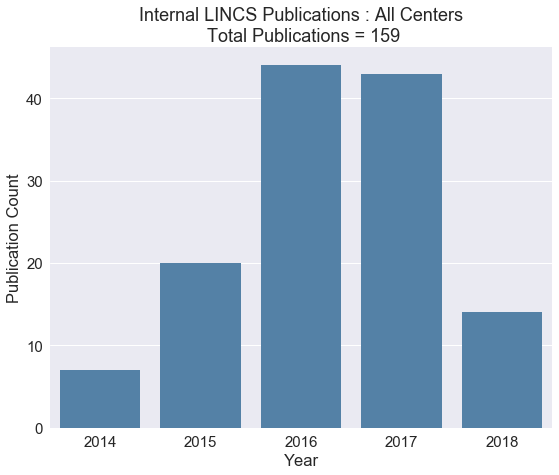

In [35]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
years = internal.dropna(subset=['YEAR'])['YEAR'].astype(int)
years = years[years>1]
sn.countplot( years, color='steelblue')
plt.title('Internal LINCS Publications : All Centers\n Total Publications = '+
          str(len( internal )))
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

### Separated By Center

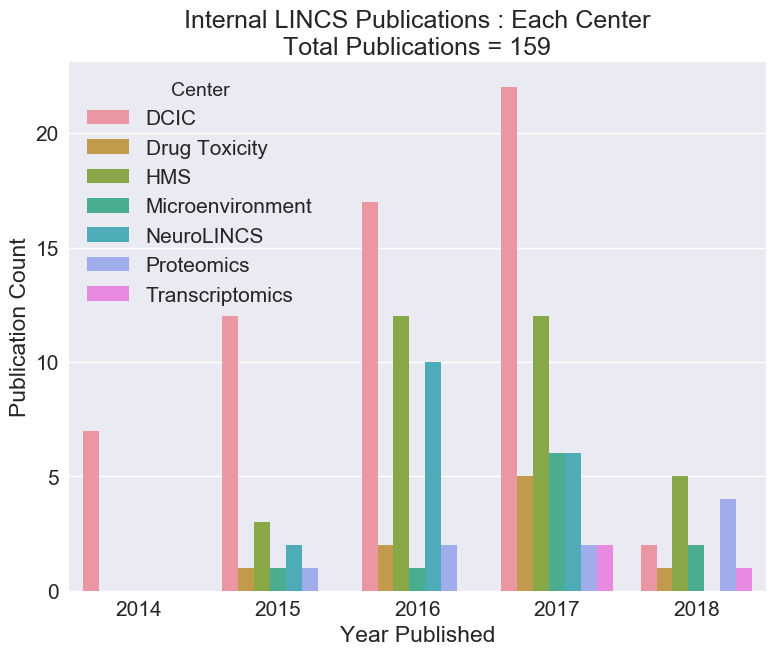

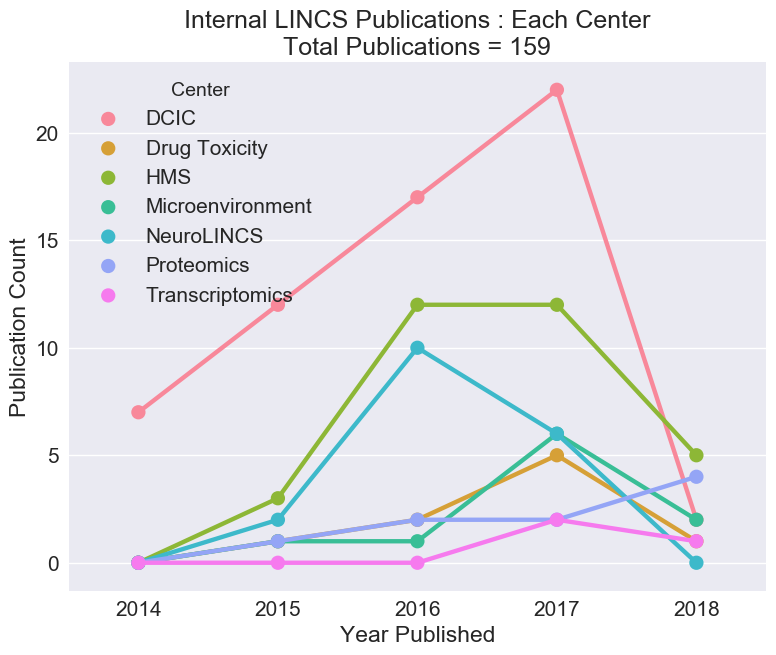

In [37]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100

internalByCenter = {}
for center in Centers: 
    internalByCenter[center] = internal.groupby('YEAR')[center].sum()
    
internalByCenter = pd.DataFrame(internalByCenter).stack().reset_index()
internalByCenter.columns = ['YEAR', 'Center', 'Count']
internalByCenter['YEAR'] = internalByCenter['YEAR'].astype(int)
internalByCenter = internalByCenter[internalByCenter['YEAR']>=1]

sn.barplot(data=internalByCenter, x='YEAR',y='Count',hue='Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( internal ) ) )
plt.xlabel('Year Published')
plt.ylabel('Publication Count');
# plt.ylim(0,10);

# Line plot
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100
sn.pointplot(data=internalByCenter, x='YEAR',y='Count',hue='Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( internal ) ) )
plt.xlabel('Year Published')
plt.ylabel('Publication Count');


## Internal LINCS CITATIONS

### Aggregated Across Centers

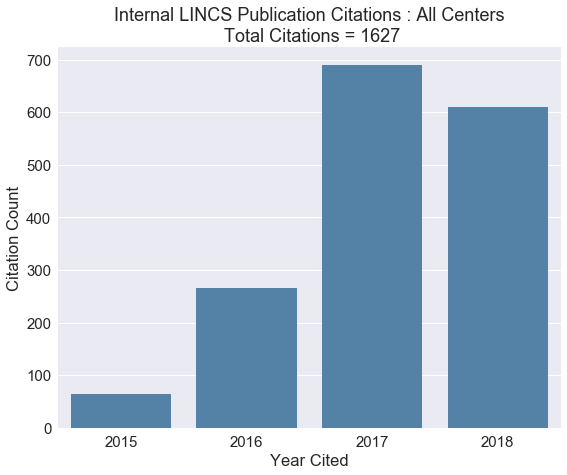

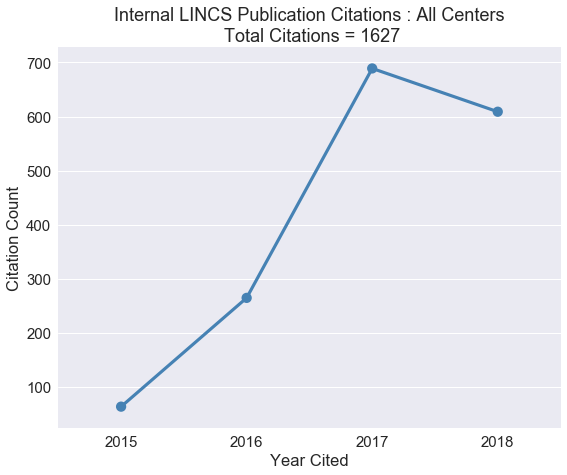

In [38]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
internal['YEAR'] = internal['YEAR'].astype(str)

from collections import Counter 
centerCounter={}     
for center in Centers:
    sub = internal.loc[internal[center]==1]
    yearCounter={}
    counter=Counter()
    for i,row in sub.iterrows(): 
        try:
            counter += Counter( row['citation_years'] )  
        except:
            counter += Counter()
    centerCounter[center]=counter
    
centerCounter = pd.DataFrame(centerCounter).fillna(0).stack().reset_index() 
centerCounter.rename(columns={'level_0':'year_cited','level_1':'LINCS Center',0:'count'}, inplace=True)
 
yearCounter_sum = centerCounter.groupby(['year_cited'])['count'].sum().reset_index()
yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0]  
missingYears = set(range(2011,2018+1)) - set(yearCounter_sum['year_cited'])  

    
sn.barplot(data=yearCounter_sum, x='year_cited', y='count', color='steelblue')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count')


# Line plot
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
sn.pointplot(data=yearCounter_sum, x='year_cited', y='count', color='steelblue')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
 

### Separated By Center

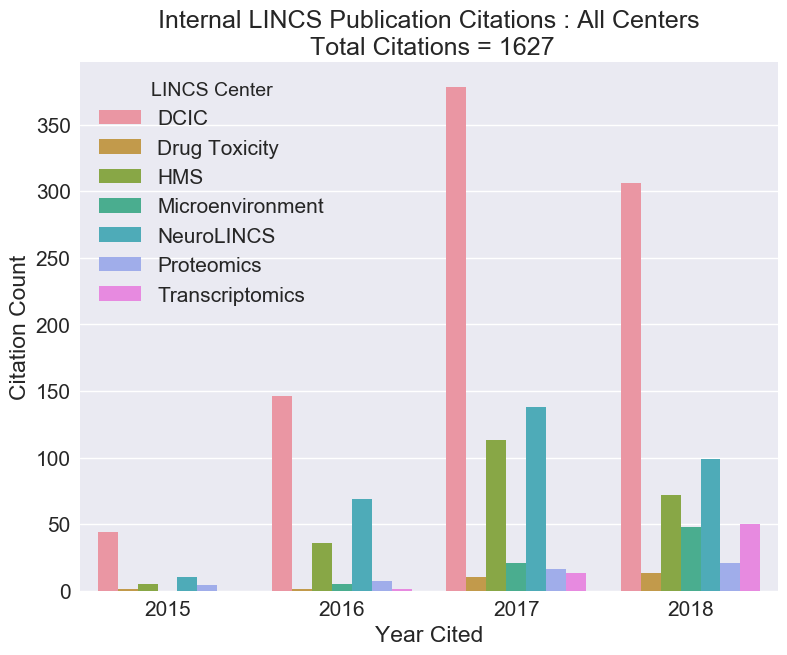

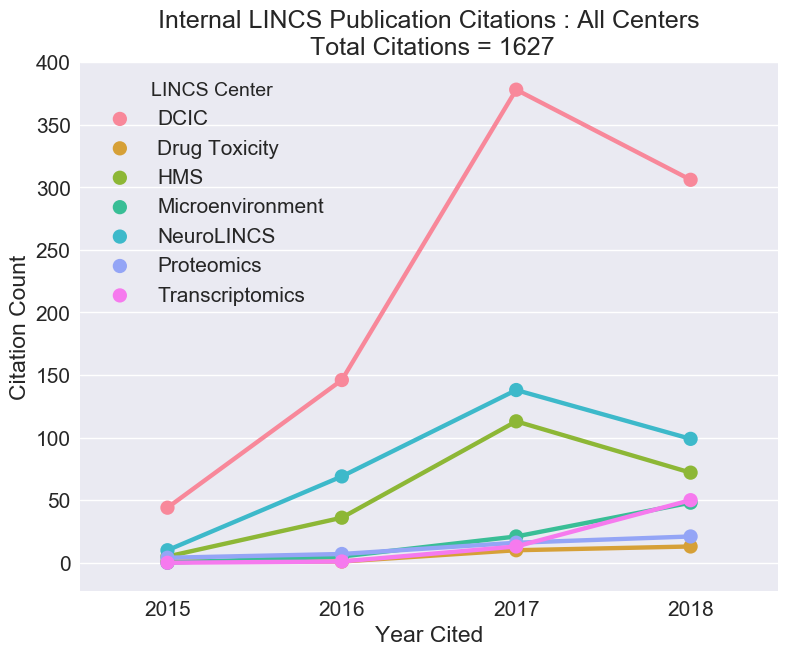

In [39]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100 

yearCounter_sum = centerCounter.groupby(['year_cited','LINCS Center'])['count'].sum().reset_index()
yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0]

sn.barplot(data=yearCounter_sum, x='year_cited', y='count', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count');

# Line plot
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100 
sn.pointplot(data=yearCounter_sum, x='year_cited', y='count', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count');



## External LINCS Publications

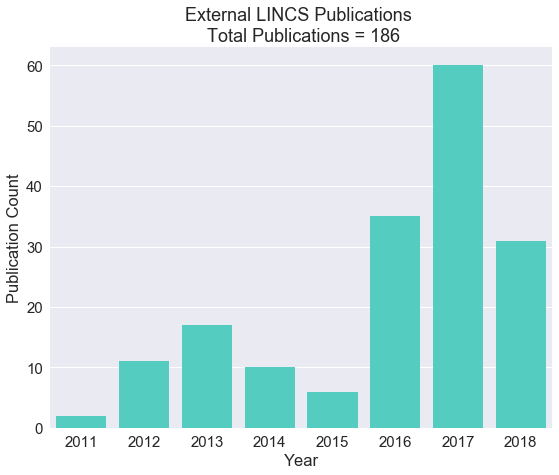

In [53]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
years = external.dropna(subset=['YEAR'])['YEAR'].astype(int)
years = years[years>1]
sn.countplot( years, color='turquoise')
plt.title('External LINCS Publications \n Total Publications = '+
          str(len( external )))
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

## External LINCS Citations

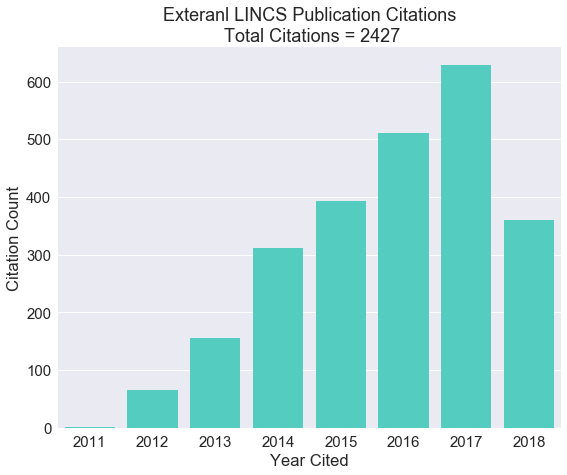

In [54]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
external['YEAR'] = external['YEAR'].astype(str)

from collections import Counter   
yearCounter=Counter()
for i,row in external.iterrows(): 
    try:
        yearCounter += Counter( row['citation_years'] )  
    except:
        yearCounter += Counter() 
    
yearCounter = pd.DataFrame(pd.Series(yearCounter)).reset_index()
yearCounter.rename(columns={'index':'year_cited',0:'count'}, inplace=True)
yearCounter = yearCounter[yearCounter['year_cited']!=0]
 
sn.barplot(data=yearCounter, x='year_cited', y='count', color='turquoise')
plt.title('Exteranl LINCS Publication Citations\n Total Citations = '+\
          str( int(sum(yearCounter['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
 